<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/dataclean_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random_state=42

In [57]:
onlinedataset=True
if onlinedataset:
  url = "https://drive.google.com/file/d/1sPoe6p1zKBOZQcQWsTTl0wzE9WCreffo/view?usp=sharing""
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  app_df=pd.read_csv(url,index_col=0)
else:
  pathtodataset="./content/credit_record.csv"
  app_df=pd.read_csv(pathtodataset,index_col=0)

In [4]:
app_df.head()

,id,gender,own_car,own_realty,num_child,income,income_type,education_level,family_status,house_type,birth_day,employment_length,mobile,work_phone,phone,email,job,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
app_df.shape

(438557, 18)

In [6]:
missing_values_count = app_df.isnull().sum()

In [7]:
missing_values_count

id                        0
gender                    0
own_car                   0
own_realty                0
num_child                 0
income                    0
income_type               0
education_level           0
family_status             0
house_type                0
birth_day                 0
employment_length         0
mobile                    0
work_phone                0
phone                     0
email                     0
job                  134203
CNT_FAM_MEMBERS           0
dtype: int64

The only column with missing values is the job column.

In [8]:
unemployed=app_df[app_df['employment_length']>=0]

In [9]:
unemployed["income_type"].unique()

array(['Pensioner'], dtype=object)

These people are unemployed and we do not need to predict their jobs

In [10]:
cond=app_df['job'].notnull()
predict_df= app_df[~cond]
predict_df=predict_df[predict_df.income_type != 'Pensioner']
train_df=app_df[cond]

In [11]:
print(predict_df.shape)
print(train_df.shape)

(58846, 18)
(304354, 18)


Id is a redundant factor but we have to keep it when we merge the predicted df later

In [12]:
train_df.drop("id",axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We can use a decision tree to predict the job of the person if we assume our data (n=304354) covers the majority of jobs that we will encounter (no outlier jobs). 

The following code is inspired by https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

In [13]:
from sklearn.model_selection import ShuffleSplit
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree
from fastai.tabular.all import *

In [14]:
dep_var="job"

In [15]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [16]:
procs = [Categorify]

In [17]:
cont,cat = cont_cat_split(train_df, 1, dep_var=dep_var)

In [18]:
to = TabularPandas(train_df, procs, cat, cont, y_names=dep_var, splits=splits)

In [19]:
len(to.train),len(to.valid)

(243483, 60871)

In [20]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [21]:
m = DecisionTreeClassifier(max_depth=18,random_state=random_state)
m.fit(xs, y)

DecisionTreeClassifier(max_depth=18, random_state=42)

In [22]:
class_names2pass = sorted(train_df["job"].unique())

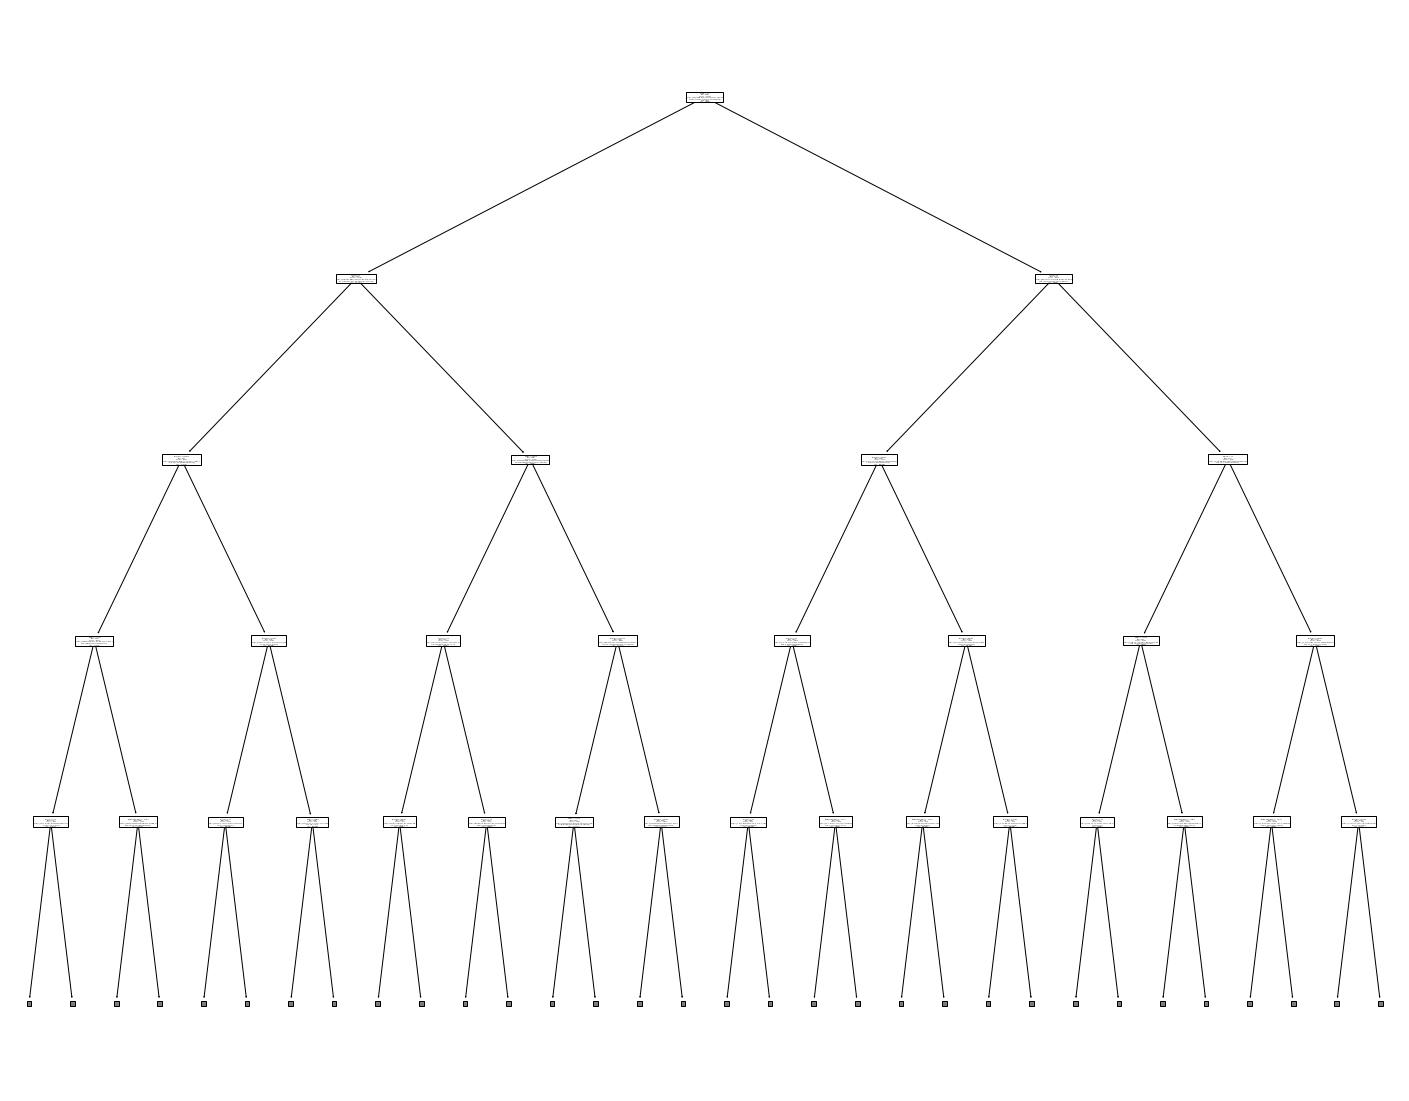

In [23]:
fig = plt.figure(figsize=(25,20))
var = plot_tree(m, 
                   feature_names=train_df.columns,  
                   class_names=class_names2pass,
                max_depth=4)

In [24]:
tree_rules = export_text(m, feature_names=list(xs.columns))

In [25]:
print(tree_rules)

|--- gender <= 1.50
|   |--- education_level <= 3.50
|   |   |--- income <= 249356.25
|   |   |   |--- employment_length <= -4419.00
|   |   |   |   |--- income_type <= 1.50
|   |   |   |   |   |--- employment_length <= -6324.00
|   |   |   |   |   |   |--- phone <= 0.50
|   |   |   |   |   |   |   |--- income <= 123750.00
|   |   |   |   |   |   |   |   |--- employment_length <= -9982.50
|   |   |   |   |   |   |   |   |   |--- own_car <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- class: 10
|   |   |   |   |   |   |   |   |   |--- own_car >  1.50
|   |   |   |   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |   |   |   |   |--- employment_length >  -9982.50
|   |   |   |   |   |   |   |   |   |--- income <= 101250.00
|   |   |   |   |   |   |   |   |   |   |--- family_status <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- family_status >  1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch

In [26]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [27]:
def hamming_distance(x,y):
  return sum(x!=y)/len(x)

In [28]:
def m_hamming_distance_accuracy(m, xs, y): return 1-hamming_distance(m.predict(xs), y)

In [29]:
# training score
m_hamming_distance_accuracy(m, xs, y)

0.6998394138399806

In [30]:
#cv score
m_hamming_distance_accuracy(m, valid_xs,valid_y)

0.6611522728392831

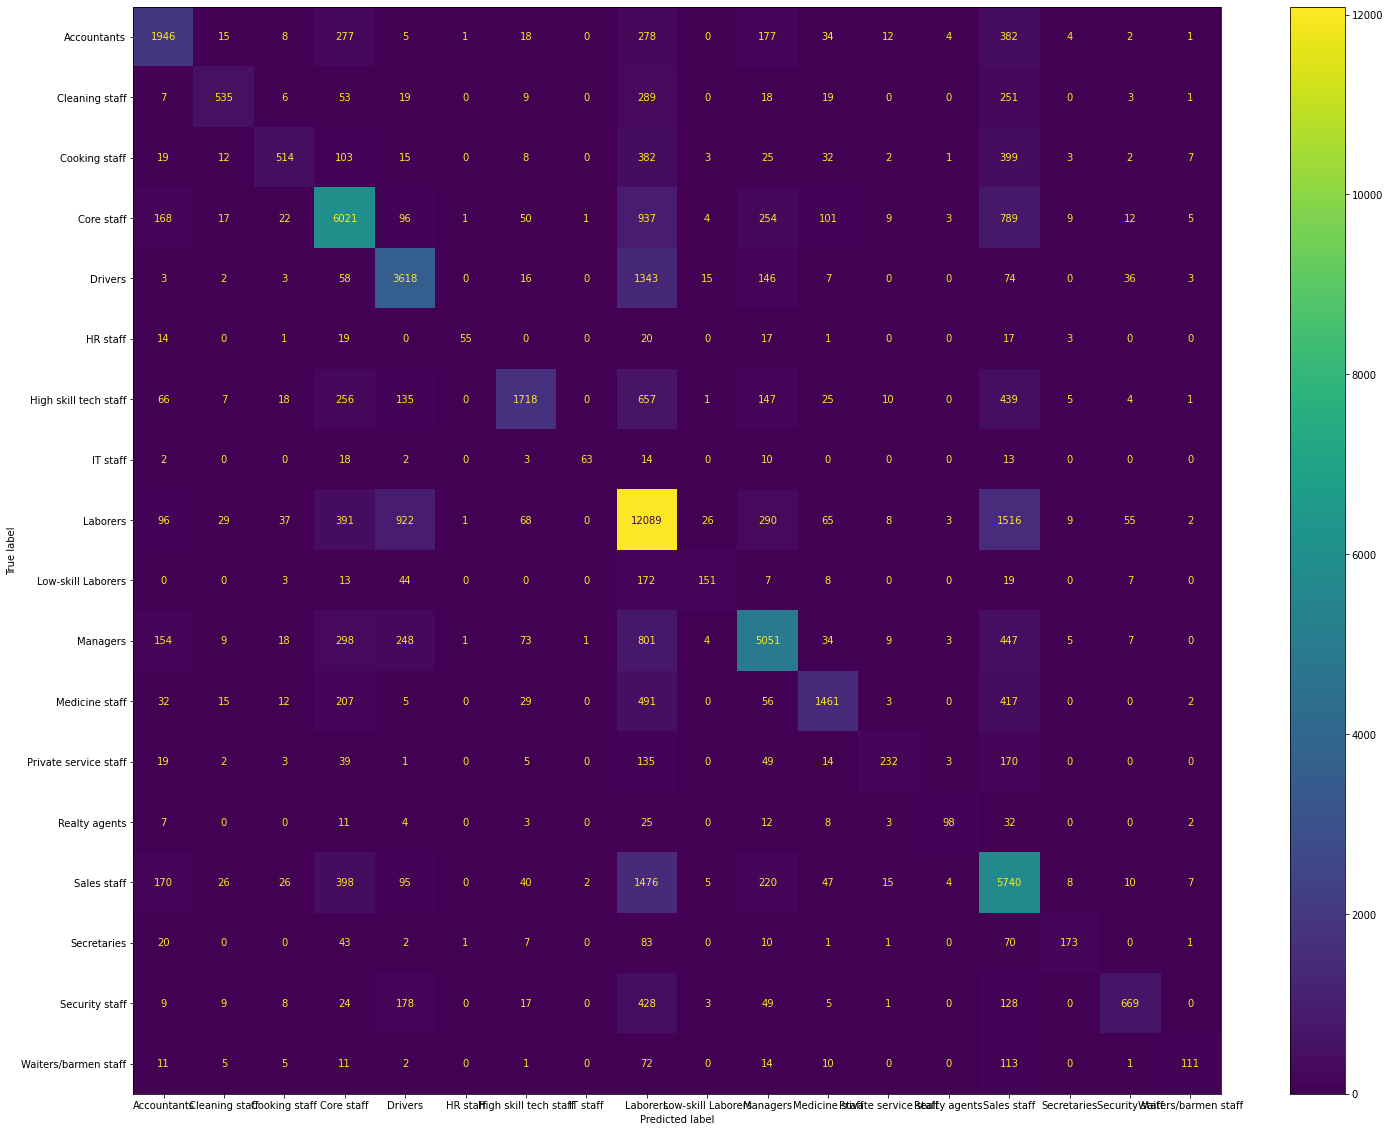

In [31]:
# get the labels to not overlay
disp=ConfusionMatrixDisplay.from_estimator(m,valid_xs, valid_y,display_labels=class_names2pass)
fig=disp.ax_.get_figure() 
fig.set_figwidth(25)
fig.set_figheight(20) 

This baseline decision tree is ok with an accuracy of ~0.7.
However, it seems to be overfitting as the cv is ~4% less than training

Perhaps we could use random forests

In [32]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True,random_state=random_state).fit(xs, y)

In [33]:
rf_m = rf(xs, y);

In [34]:
m_hamming_distance_accuracy(rf_m, xs, y), m_hamming_distance_accuracy(rf_m, valid_xs, valid_y)

(0.9433964588903537, 0.8861362553596951)

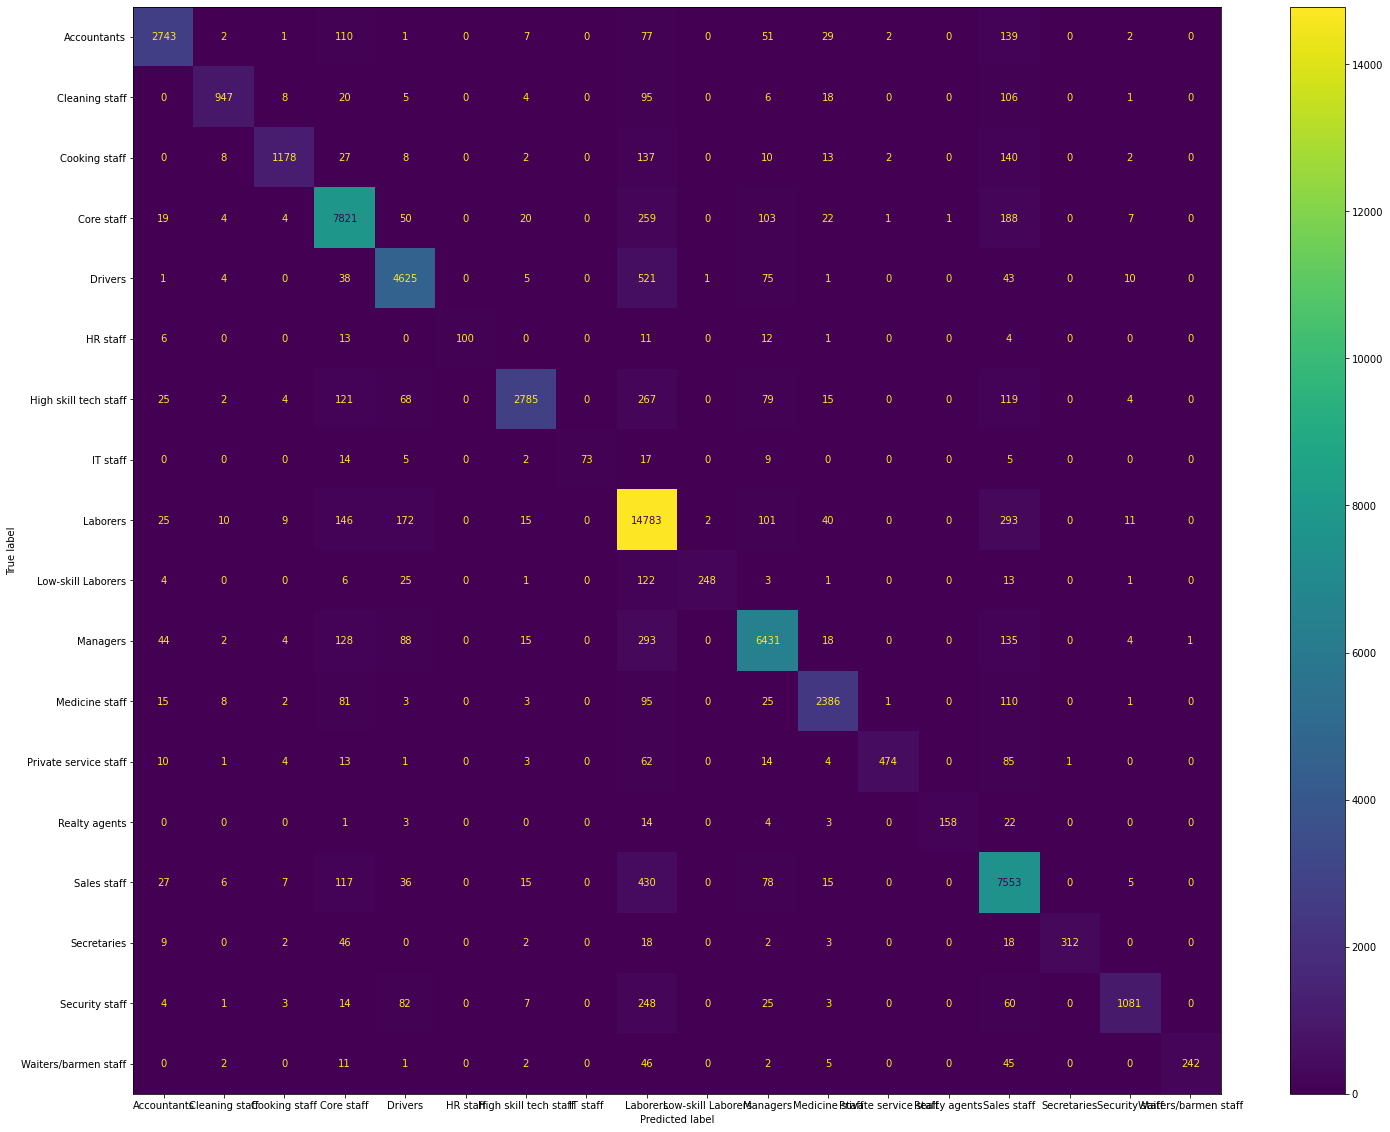

In [35]:
disp=ConfusionMatrixDisplay.from_estimator(rf_m,valid_xs, valid_y,display_labels=class_names2pass)
fig=disp.ax_.get_figure() 
fig.set_figwidth(25)
fig.set_figheight(20) 

Random forests do way better! However, it still seems to be overfitting.

Feature Importance

In [36]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [37]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
10,birth_day,0.238360
11,employment_length,0.236197
9,income,0.137046
0,gender,0.061899
4,education_level,0.060267
5,family_status,0.038104
3,income_type,0.036070
15,CNT_FAM_MEMBERS,0.032537
2,own_realty,0.026538
6,house_type,0.024437


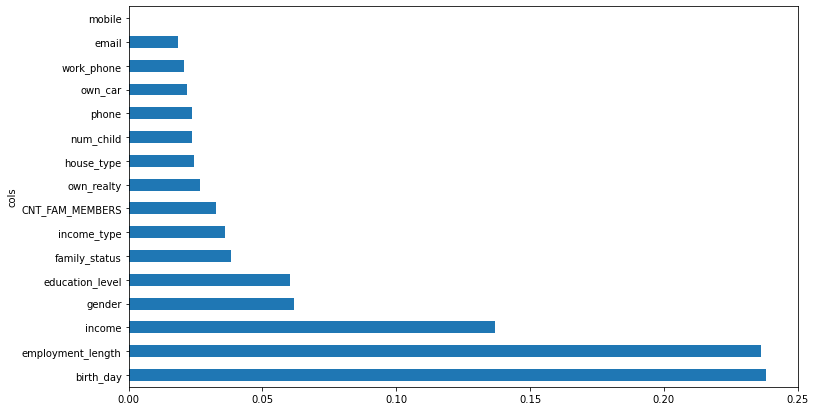

In [38]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);

In [39]:
app_df["mobile"].unique()

array([1])

Everyone has a mobile phone, we should drop this redundant factor (cardinality=1) to reduce the dimesionality of our data

In [40]:
prev_df=app_df.drop(columns=["mobile"],inplace=True)

We could also use gradient boosted trees to predict the jobs

In [41]:
from lightgbm import LGBMClassifier

In [42]:
boosted_tree=LGBMClassifier(random_state=random_state)

In [43]:
boosted_tree.fit(xs,y)

LGBMClassifier()

In [44]:
boosted_tree.score(valid_xs,valid_y)

0.4562599595866669

In [45]:
m_hamming_distance_accuracy(boosted_tree, xs, y), m_hamming_distance_accuracy(boosted_tree, valid_xs, valid_y)

(0.47643983358181063, 0.4562599595866669)

It seems there is something wrong with our current lgbm, perhaps we could change the hyper parameters

We would be using the random forest to predict the missing jobs

In [46]:
# use same pipeline to convert df
predict_to = TabularPandas(predict_df, procs, cat, cont, y_names=dep_var)
predict_xs = predict_to.train.xs
predicted_jobs=rf_m.predict(predict_xs)
predicted_jobs_names=[class_names2pass[i] for i in predicted_jobs]
concat_df=predict_xs.assign(job=predicted_jobs_names)
app_df= app_df.fillna(concat_df)

In [47]:
app_df["employment_length"].describe()

count    438557.000000
mean      60563.675328
std      138767.799647
min      -17531.000000
25%       -3103.000000
50%       -1467.000000
75%        -371.000000
max      365243.000000
Name: employment_length, dtype: float64

In [48]:
app_df[app_df["employment_length"]!=365243]["employment_length"].describe()

count    363228.000000
mean      -2623.052700
std        2399.514253
min      -17531.000000
25%       -3512.000000
50%       -1924.000000
75%        -915.000000
max         -12.000000
Name: employment_length, dtype: float64

In [49]:
pensioners=app_df[app_df["employment_length"]==365243]
pensioners["income_type"].unique()

array(['Pensioner'], dtype=object)

In [50]:
pensioners["birth_day"].describe()

count    75329.000000
mean    -21715.424272
std       1839.857354
min     -25201.000000
25%     -22981.000000
50%     -21927.000000
75%     -20807.000000
max      -8145.000000
Name: birth_day, dtype: float64

Having the pensioners with employment length = 365243 is both incorrect (1000 years) and will definitely affect the feature scaling of employment length. Thus , we propose that the retirement age is the median of the dataset (21927) and employment length will be max(median-age,0).

In [51]:
pensioners["employment_length"]

7         365243
8         365243
9         365243
76        365243
160       365243
           ...  
438549    365243
438550    365243
438551    365243
438552    365243
438555    365243
Name: employment_length, Length: 75329, dtype: int64

In [52]:
pd.options.mode.chained_assignment = None
pensioners["employment_length"]=pensioners.apply(lambda x : max(-21927-x["birth_day"],0),axis=1)

In [53]:
pensioners=pensioners.fillna("Pensioner")

In [54]:
app_df.assign(employment_length=pensioners.employment_length,job=pensioners.job)

,id,gender,own_car,own_realty,num_child,income,income_type,education_level,family_status,house_type,birth_day,employment_length,work_phone,phone,email,job,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,NaN,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,NaN,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,NaN,0,0,0,NaN,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,NaN,0,1,1,NaN,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,NaN,0,1,1,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,790.0,0,0,0,Pensioner,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,NaN,0,0,0,NaN,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,NaN,1,0,0,NaN,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,0.0,0,0,0,Pensioner,2.0


In [55]:
app_df

,id,gender,own_car,own_realty,num_child,income,income_type,education_level,family_status,house_type,birth_day,employment_length,work_phone,phone,email,job,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Core staff,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Core staff,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,0,0,0,NaN,2.0


In [56]:
app_df.to_csv("cleaned_application.csv")